## Applying aRchaic on Lindo 2016 data

We apply aRchaic on Lindo et al data comprising of 25 moderns and 25 ancient samples. All the samples were clipped in the first base of the read. The metadata for the modern and the ancient samples are available [here](utilities/Lindo_metadata.txt)

We start by reading in the data for the ancient and the modern samples.

In [50]:
options(warn=-1)
library(aRchaic)
library(CountClust)
library(maptpx)
library(grid)
library(gridBase)
library(dplyr)

In [ ]:
## We build the signature counts data from mutation feature file format

dir <- "../data/Lindo2016ancients/";
out <- aggregate_bin_counts(dir, breaks = c(-1, seq(1,20,1), 25, 35))
save(out,
     file="../processed_data/lindo2016ancients-counts-table.rda")


dir <- "../data/Lindo2016moderns/";
out <- aggregate_bin_counts(dir, breaks = c(-1, seq(1,20,1), 25, 35))
save(out,
     file="../processed_data/lindo2016moderns-counts-table.rda")



In [8]:
lindoancient_data <- get(load("../processed_data/lindo2016ancients-counts-table.rda"))
lindomoderns_data <- get(load("../processed_data/lindo2016moderns-counts-table.rda"))

## We club the signatures from the + and the - strands 

lindoancient_data_clubbed <- aRchaic::club_signature_counts(lindoancient_data)
lindomoderns_data_clubbed <- aRchaic::club_signature_counts(lindomoderns_data)


In [9]:
head(lindomoderns_data_clubbed[,1:5])  ## Lindo et al moderns signature data

,AAC->AAA_10,AAC->AAA_11,AAC->AAA_12,AAC->AAA_13,AAC->AAA_14
S001_all_chr.q30,89,85,135,61,61
S002_all_chr.q30,76,79,100,80,92
T004_all_chr.q30,13,11,12,6,6
T008_all_chr.q30,18,26,26,9,21
t012_all_chr.q30,5,12,4,9,11
T015_all_chr.q30,37,37,50,34,41


In [10]:
head(lindoancient_data_clubbed[,1:5]) ## Lindo et al ancient signatures data

,AAC->AAA_10,AAC->AAA_11,AAC->AAA_12,AAC->AAA_13,AAC->AAA_14
125_all_chr.q30,0,2,2,0,1
158_all_chr.q30,18,25,16,13,19
163_all_chr.q30,0,2,1,2,2
167_all_chr.q30,2,0,2,3,3
168_all_chr.q30,30,31,29,35,31
181_all_chr.q30,38,44,45,55,56


In [4]:
## Read in the metadata for moderns
lindo_moderns_metadata <- read.table("../utilities/Lindo_metadata.txt")
head(lindo_moderns_metadata)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10
S001,Nextera,1,0.9042838,6.34220,125,Tru-Seq,4,0.32820014,2.03254
S002,Tru-Seq,1,0.9309504,8.62802,158,Tru-Seq,4,0.53622187,5.25787
T004,Tru-Seq,1,0.7050985,2.80743,163,Tru-Seq,4,0.06561192,1.75727
T008,Nextera,1,0.8014746,10.65550,167,Tru-Seq,4,0.34189826,1.85701
T012,Tru-Seq,1,0.6633715,2.57248,168,Tru-Seq,4,0.84163529,12.85290
T015,Tru-Seq,1,0.9054928,9.87665,181,Tru-Seq,4,0.88700300,12.74290


In [11]:
## match the signature names for the moderns and ancients data and keep the ones occurring in both
pooled_names <- intersect(colnames(lindoancient_data_clubbed), 
                          colnames(lindomoderns_data_clubbed))
filtered_ancients <- lindoancient_data_clubbed[, match(pooled_names, colnames(lindoancient_data_clubbed))]
filtered_moderns <- lindomoderns_data_clubbed[, match(pooled_names, colnames(lindomoderns_data_clubbed))]

In [12]:
lindo_pooled <- rbind(filtered_ancients, filtered_moderns) ## Pooling modern and ancient data

In [14]:
modern_names <- as.character(sapply(rownames(filtered_moderns), function(x) strsplit(x, "[_]")[[1]][1]))
## extracting the names of the moderns
modern_names[1:5]

[1] "S001" "S002" "T004" "T008" "t012"

In [16]:
temp <- aRchaic::filter_signatures_only_location(filtered_moderns, max_pos = 20)
## Extracting number of mutations per position on the read 

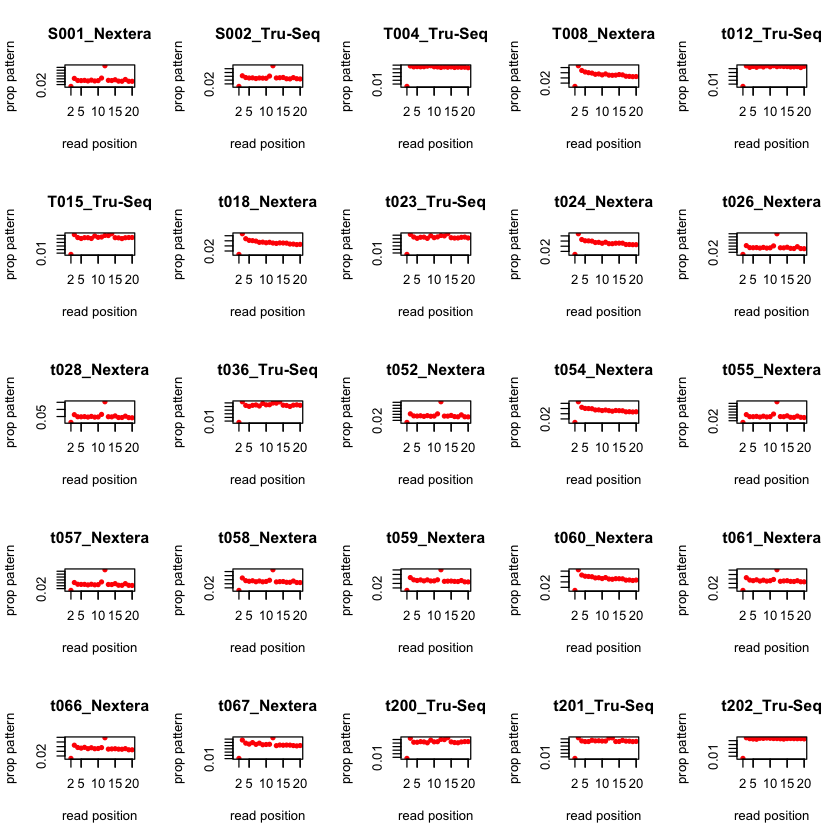

In [17]:
par(mfrow=c(5,5))
for(k in 1:25){
  plot(1:20, temp[k,]/sum(temp[k,], na.rm=TRUE), col="red", pch=20, main=paste0(modern_names[k], "_", lindo_moderns_metadata[k,2]), xlab="read position", ylab="prop pattern")
  axis(1, at=c(2, 5, 10, 15, 20), c(2, 5, 10, 15, 20))
}

### Clustering based on mutation signatures

We now perform a clustering of the 50 samples (25 moderns + 25 ancients) based on the signature frequencies. We use a Grade of Membership model, independent version, which is a modified version of the method proposed by Shiraishi and Stephens. 

We first extract the signature values to feed into the clustering model.

In [18]:
##  Extracting independent signature factor values 

signature_set <- colnames(lindo_pooled)
sig_split <- t(sapply(1:length(signature_set), function(x) return(strsplit(signature_set[x], "")[[1]][1:8])))
new_sig_split <- matrix(0, dim(sig_split)[1], 5);
new_sig_split[,1] <- sig_split[,1]
new_sig_split[,2] <- sig_split[,2]
new_sig_split[,3] <- sapply(1:length(signature_set), function(x) return(paste(sig_split[x,3:6], collapse="")))
new_sig_split[,4] <- sig_split[,7]
new_sig_split[,5] <- sig_split[,8]

levels(new_sig_split[,1]) <- c("0", "1", "2", "3", "4")

pos <- t(sapply(1:length(signature_set), function(x)
{
  y = strsplit(signature_set[x], "")[[1]]
  return(paste(y[10:length(y)], collapse=""))
}))



mat <- matrix(0, dim(new_sig_split)[1], dim(new_sig_split)[2])
for(k in 1:dim(new_sig_split)[2]){
  temp <- as.factor(new_sig_split[,k])
  mat[,k] <- as.numeric(as.matrix(plyr::mapvalues(temp, from = levels(temp), to = 0:(length(levels(temp))-1))))
}

pos <- as.numeric(pos)
pos <- pos - min(pos)
pos <- factor(pos, levels = 0:20)

signatures <- mat;
signature_pos <- cbind.data.frame(signatures, pos)

In [19]:
## Apply the indepndent Grade of Membership Model

## out <- topics(lindo_pooled, K=5, tol=100, model="independent", signatures = signature_pos)
## save(out, file="../processed_data/maptpx-runs/lindo2016-maptpx-independent-K-5.rda")

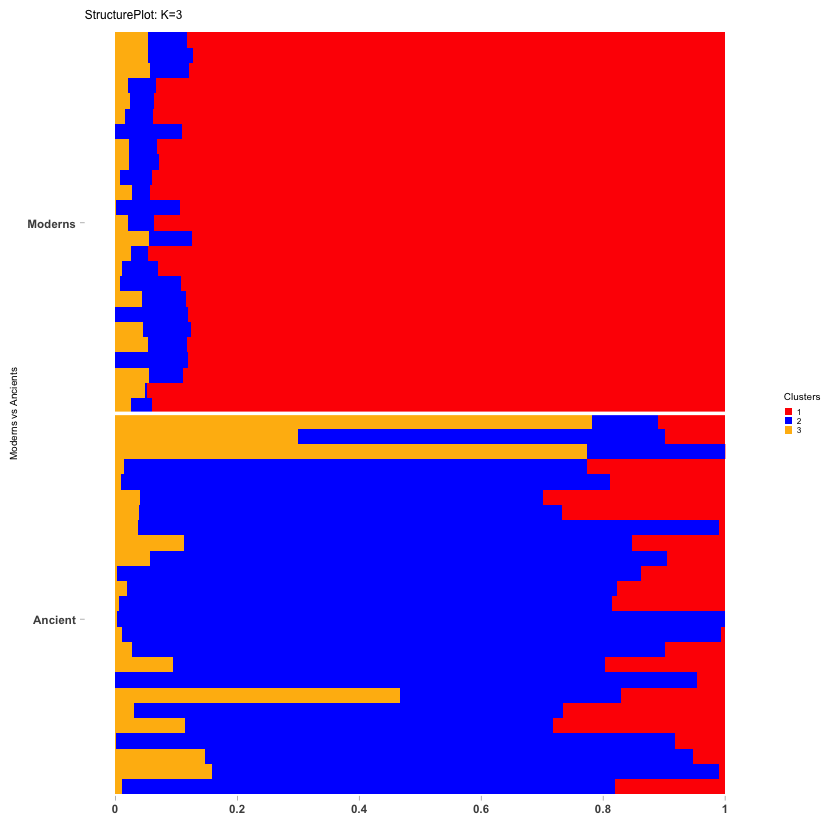

In [20]:
## Visualizing patterns of membership patterns from Grade of Membership Model (CountClust)

out <- get(load("../processed_data/maptpx-runs/lindo2016-maptpx-independent-K-3.rda"))

labs <- c(rep("Ancient", 25), rep("Moderns", 25))
omega <- out$omega

cols1 <- c("red","blue","darkgoldenrod1","cyan","firebrick", "green",
                 "hotpink","burlywood","yellow","darkgray","deepskyblue","darkkhaki",
                 "brown4","darkorchid","magenta","yellow", "azure1","azure4")

annotation <- data.frame(
  sample_id = paste0("X", c(1:NROW(omega))),
  tissue_label = factor(labs)
)

CountClust::StructureGGplot(omega = omega,
                            annotation = annotation,
                            palette = cols1,
                            yaxis_label = "Moderns vs Ancients",
                            order_sample = FALSE,
                            figure_title = paste0("StructurePlot: K=", dim(omega)[2],""),
                            axis_tick = list(axis_ticks_length = .1,
                                             axis_ticks_lwd_y = .1,
                                             axis_ticks_lwd_x = .1,
                                             axis_label_size = 7,
                                             axis_label_face = "bold"))

In [38]:
## Visualizing clusters of signatures using Logo plots 

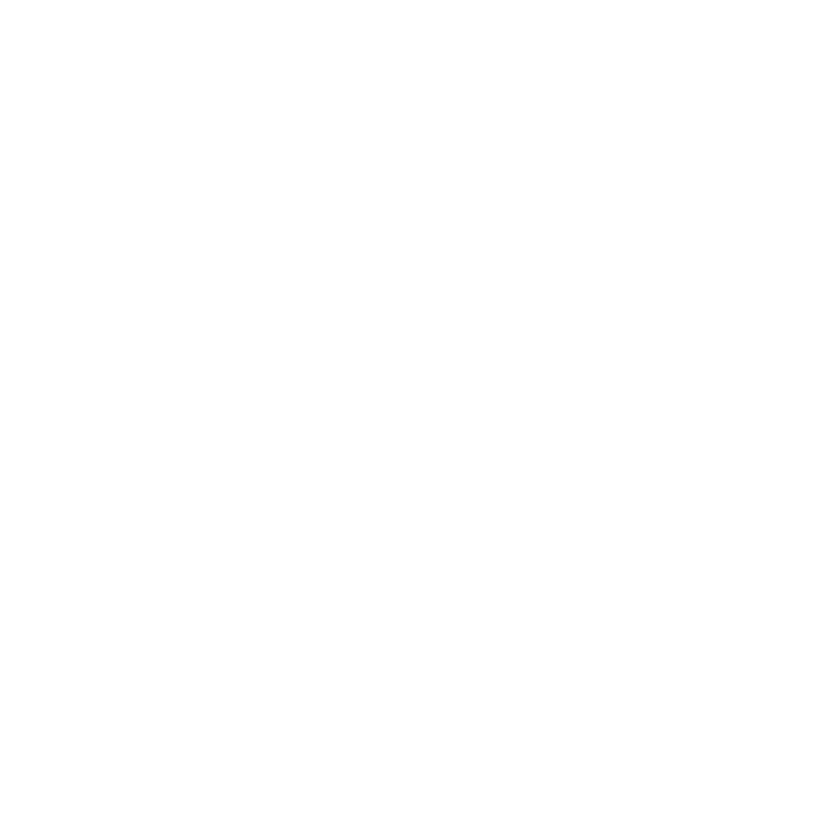

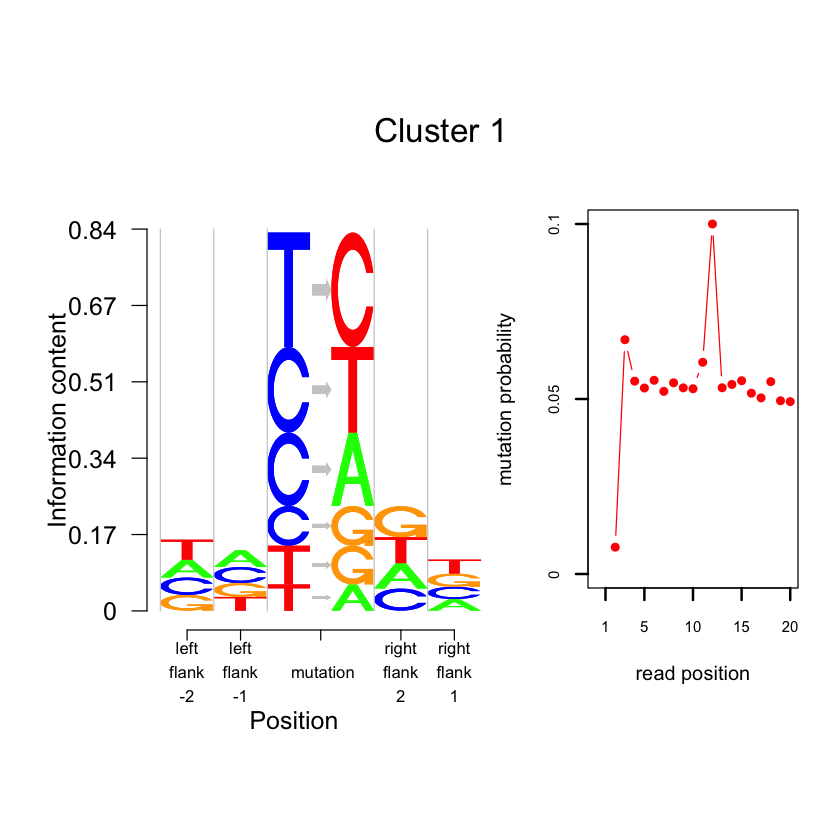

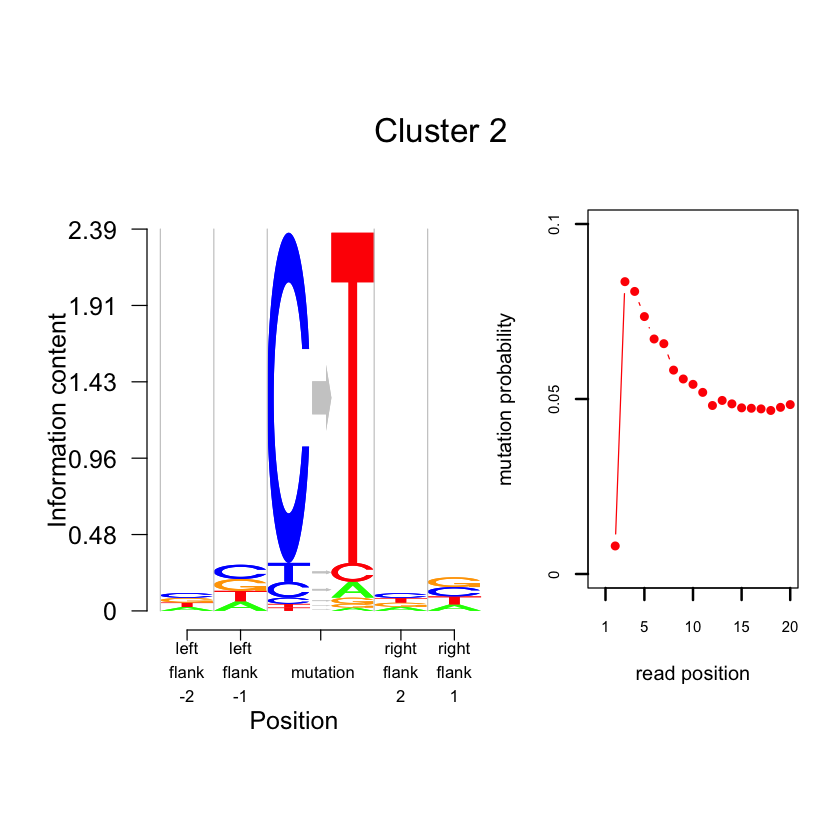

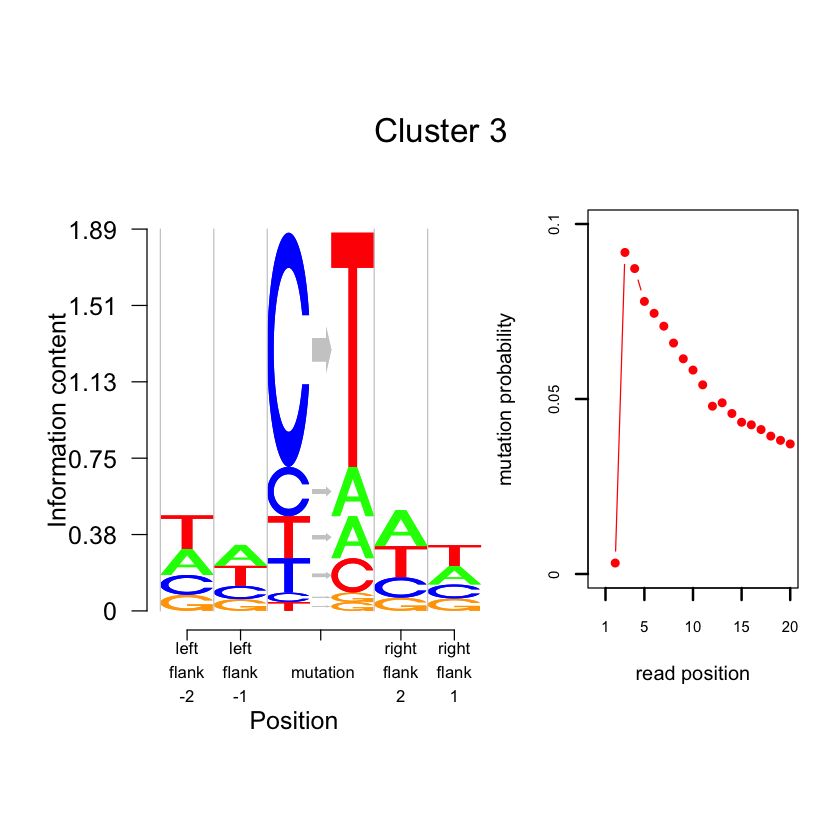

In [39]:
plot.new()
aRchaic::damageLogo_pos(out$theta, ic.scale = TRUE, renyi_alpha = 100)

### Breakdown of the T->AAA

A very important feature that showed up in the above analysis are the dominance of the T->A mutations flanked by Ts and As on the left and right. We still do not have a clear idea what could be the cause behind these patterns. So, we decided to take a closer look at the individual samples with high membership in the third cluster, namely the 23rd and the 25th ancient samples. Two patterns that seemed very strong are AAT->AAA and TTA->TTT. We investigate these two patterns.


In [43]:
tab <- read.csv("../data/Lindo2016ancients/939_all_chr.q30.csv", header=FALSE)
tbl_df(tab) %>% filter(V1 %in% c("AAT->AAA", "TTA->TTT")) %>% arrange(desc(V4)) %>% head()

## 939 is the oldest ancient samples (25th ancient in the plot from the bottom)

V1,V2,V3,V4
AAT->AAA,90,3,344
AAT->AAA,87,6,238
TTA->TTT,4,89,229
AAT->AAA,86,7,222
AAT->AAA,89,4,217
TTA->TTT,7,86,203


In [44]:
tab <- read.csv("../data/Lindo2016ancients/468_all_chr.q30.csv", header=FALSE)
tbl_df(tab) %>% filter(V1 %in% c("AAT->AAA", "TTA->TTT")) %>% arrange(desc(V4)) %>% head()

## an ancient sample not having high membership in 3rd cluster

V1,V2,V3,V4
TTA->TTT,82,17,4
AAT->AAA,55,44,3
TTA->TTT,24,75,3
AAT->AAA,20,79,3
TTA->TTT,85,14,3
AAT->AAA,66,24,3


In [45]:
tab <- read.csv("../data/Lindo2016ancients/525_all_chr.q30.csv", header=FALSE)
tbl_df(tab) %>% filter(V1 %in% c("AAT->AAA", "TTA->TTT")) %>% arrange(desc(V4)) %>% head()

## the 23rd ancient sample (also high membership in 3rd cluster)

V1,V2,V3,V4
TTA->TTT,6,93,8
AAT->AAA,50,5,7
TTA->TTT,13,50,7
AAT->AAA,59,5,7
TTA->TTT,6,45,7
AAT->AAA,65,5,7


In [46]:
tab <- read.csv("../data/Lindo2016ancients/163_all_chr.q30.csv", header=FALSE)
tbl_df(tab) %>% filter(V1 %in% c("AAT->AAA", "TTA->TTT")) %>% arrange(desc(V4)) %>% head()

## another ancient from Lindo's data that has low membership in 3rd cluster

V1,V2,V3,V4
TTA->TTT,9,37,1
AAT->AAA,83,15,1


In [47]:
tab <- read.csv("../data/Lindo2016moderns/S001_all_chr.q30.csv", header=FALSE);
tbl_df(tab) %>% filter(V1 %in% c("AAT->AAA", "TTA->TTT")) %>% arrange(desc(V4)) %>% head()

## a modern from Lindo's data

V1,V2,V3,V4
TTA->TTT,87,12,12
TTA->TTT,74,25,8
AAT->AAA,87,12,8
AAT->AAA,49,50,7
AAT->AAA,39,60,6
AAT->AAA,55,44,6


In [48]:
tab<- read.csv("../data/1000Gmoderns/NA19675.mapped.ILLUMINA.bwa.MXL.low_coverage.20120522.q30.csv", header=FALSE)
tbl_df(tab) %>% filter(V1 %in% c("AAT->AAA", "TTA->TTT")) %>% arrange(desc(V4)) %>% head()

## a South American modern  (1000 Genomes) that shows high values of these pattern 

V1,V2,V3,V4
TTA->TTT,4,71,117
AAT->AAA,71,4,103
TTA->TTT,5,70,92
AAT->AAA,70,5,80
TTA->TTT,3,72,57
AAT->AAA,69,6,55


In [49]:
tab<- read.csv("../data/1000Gmoderns/HG00096.mapped.ILLUMINA.bwa.GBR.low_coverage.20120522.q30.csv", header=FALSE)
tbl_df(tab) %>% filter(V1 %in% c("AAT->AAA", "TTA->TTT")) %>% arrange(desc(V4)) %>% head()

## a GBR modern (1000 Genomes) that does not show these patterns 

V1,V2,V3,V4
AAT->AAA,99,0,3
TTA->TTT,1,98,3
TTA->TTT,5,94,3
AAT->AAA,72,27,3
AAT->AAA,91,8,2
TTA->TTT,83,16,2


In [51]:
sessionInfo()

R version 3.3.1 (2016-06-21)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: OS X 10.12 (Sierra)

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] dplyr_0.5-1      aRchaic_0.99.0   gridExtra_2.2.1  gridBase_0.4-7  
[5] maptpx_1.9-3     CountClust_0.1.2 ggplot2_2.2.1   

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-5        gtools_3.5.0        modeltools_0.2-21  
 [4] slam_0.1-40         repr_0.10           reshape2_1.4.2.9000
 [7] lattice_0.20-34     colorspace_1.3-1    stats4_3.3.1       
[10] mgcv_1.8-16         DBI_0.5-1           withr_1.0.2        
[13] uuid_0.1-2          plyr_1.8.4          stringr_1.1.0      
[16] munsell_0.4.3       gtable_0.2.0        devtools_1.12.0    
[19] evaluate_0.10       memoise_1.0.0       knitr_1.15.1       
[22] permute_0.9-4       flexmix_2.3-13      parall